In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
data_dir = r"dataset"
oil=[]
for file in os.listdir(data_dir):
    oil+=[file]
print(oil)
print(len(oil))

['Plain', 'Pothole']
2


In [5]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_directory("dataset",
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training')
test_generator = train_datagen.flow_from_directory("dataset",
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation'
                                                )

Found 213 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [6]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [8]:
base_model = tf.keras.applications.ResnetV2(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model1 = Sequential()
model1.add(base_model)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,294,850
Trainable params: 3,272,834
Non-trainable params: 22,016
_________________________________________

In [9]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model1.fit(train_generator,epochs=10,validation_data=test_generator)

Epoch 1/10
11/11 [==============================] - 24s 1s/step - loss: 0.1623 - accuracy: 0.9249 - precision: 0.8858 - recall: 0.9108 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 5.3515 - val_accuracy: 0.4725 - val_precision: 0.4725 - val_recall: 0.4725 - val_sensitivity_at_specificity: 0.8242 - val_specificity_at_sensitivity: 0.7363
Epoch 2/10
11/11 [==============================] - 7s 597ms/step - loss: 0.0210 - accuracy: 0.9953 - precision: 0.9813 - recall: 0.9859 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 11.9657 - val_accuracy: 0.4725 - val_precision: 0.4725 - val_recall: 0.4725 - val_sensitivity_at_specificity: 0.4725 - val_specificity_at_sensitivity: 0.4725
Epoch 3/10
11/11 [==============================] - 7s 641ms/step - loss: 0.0060 - accuracy: 1.0000 - precision: 0.9860 - recall: 0.9953 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 11.8936 - val_accu

In [10]:
model1.save("models/resnetv2.h5")

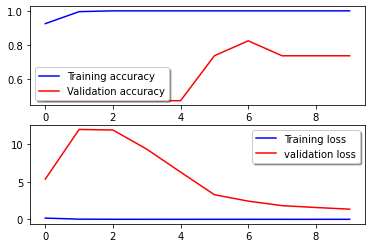

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

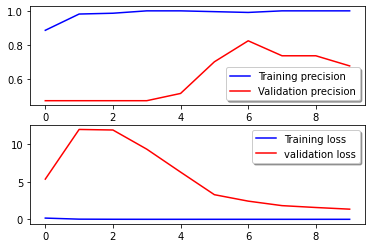

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

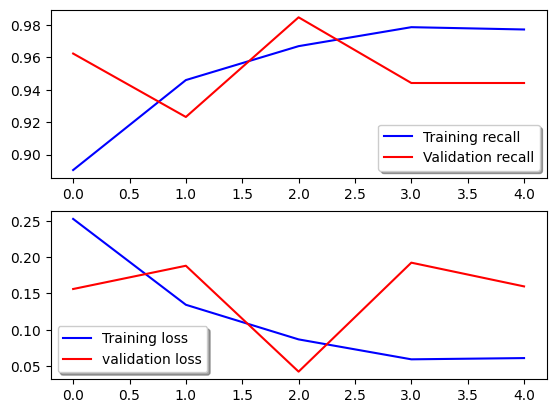

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall_1'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall_1'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

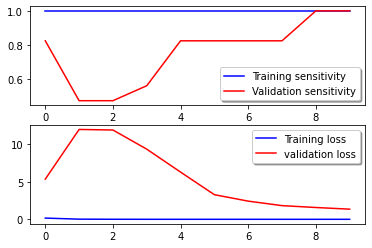

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

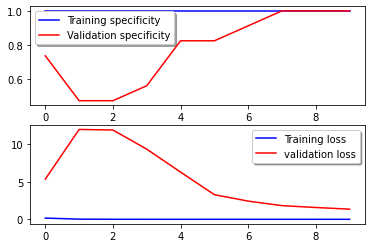

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model_predict = model1.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


91/91 - 2s


Confusion matrix, without normalization
[[26 17]
 [25 23]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

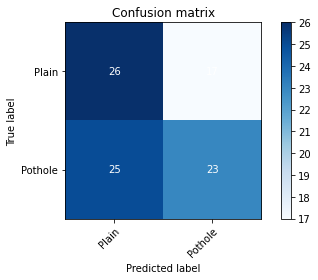

In [17]:
y_true = test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Plain', 'Pothole'],
                      title='Confusion matrix')